# 00. Table of Content
### 01. Importing Libraries & Datasets
### 02. Subsetting, wrangling, and cleaning time-series data
### 03. Time series analysis: decomposition
### 04. Testing for stationarity
### 05. Stationarizing the WHR Data for Germany

# 01. Importing Libraries & Datasets

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'yWsgyabYcvmC5ccZx8kK'

In [3]:
# Importing the World Bank Data 
# "Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)" variable.

data = quandl.get_table('WB/DATA',series_id='SH.ALC.PCAP.LI')

In [4]:
data.head()

,series_id,country_code,country_name,year,value
None,,,,,
0,SH.ALC.PCAP.LI,ZWE,Zimbabwe,2019,3.62809
1,SH.ALC.PCAP.LI,ZWE,Zimbabwe,2018,4.67000
2,SH.ALC.PCAP.LI,ZWE,Zimbabwe,2016,4.80000
3,SH.ALC.PCAP.LI,ZWE,Zimbabwe,2015,3.74794
4,SH.ALC.PCAP.LI,ZWE,Zimbabwe,2010,3.31307


In [5]:
data.shape

(1639, 5)

In [6]:
data.columns

Index(['series_id', 'country_code', 'country_name', 'year', 'value'], dtype='object')

In [7]:
data.describe()

,year,value
count,1639.000000,1639.000000
mean,2011.874924,5.615227
std,6.616171,3.938675
min,2000.000000,0.000000
25%,2005.000000,2.287410
50%,2015.000000,5.170961
75%,2018.000000,8.635347
max,2019.000000,20.500000


In [8]:
data.groupby('country_name').agg({'value':['mean', 'median']})

value          
                                 mean    median
country_name                                   
Afghanistan                  0.068134  0.016180
Africa Eastern and Southern  4.960619  4.908242
Africa Western and Central   5.286458  5.212817
Albania                      5.777940  5.297400
Algeria                      0.609026  0.584400
...                               ...       ...
Vietnam                      8.530000  8.530000
World                        5.673363  5.720461
Yemen, Rep.                  0.067361  0.058430
Zambia                       4.159417  3.727650
Zimbabwe                     3.704379  3.628090

[239 rows x 2 columns]

In [9]:
# Create crosstab for country_name and year
crosstab = pd.crosstab(data['year'], data['country_name'], dropna=False)


In [10]:
# copy to cliboard
crosstab.to_clipboard()

#### Quandle Data on Alcohol Cosumption
Dataset includes 239 countries from the years 2000 - 2019 with a minimum of 0 liters pure alcohol per capita to 20.5 liter pure alcohol per capita. Disclaimer: Not all countries have entries for all years, some years are missing. Reference: If one beer of 335 ml contains ~5% alcohol = 18 ml then 20.5 liters pure alcohol (the max value in the dataset) would add up to ~ 1139 beers per year which makes up for average 3,1 beers per day per person. I picked this dataset to understand if there might be a relation between alcohol consumption and happiness rankings which I will investigate.

In [11]:
subset = data.groupby('year').agg({'value':['mean']})

In [12]:
subset

,value
,mean
year,
2000,5.396774
2005,5.472472
2010,5.526194
2015,5.470964
2016,6.115470
2018,5.965525
2019,5.360373


In [13]:
# Reset the index to flatten the MultiIndex column labels
subset.reset_index(inplace=True)

In [14]:
subset

,year,value
,,mean
0,2000,5.396774
1,2005,5.472472
2,2010,5.526194
3,2015,5.470964
4,2016,6.115470
5,2018,5.965525
6,2019,5.360373


In [15]:
# Rename the column to remove the aggregation label
subset.columns = ['year', 'value']

In [16]:
subset.dtypes

year       int64
value    float64
dtype: object

In [17]:
# Set year to index
subset.set_index('year', inplace=True)

In [18]:
subset.columns

Index(['value'], dtype='object')

In [19]:
# Change data format
subset.index = pd.to_datetime(subset.index, format='%Y')

In [20]:
subset

,value
year,
2000-01-01,5.396774
2005-01-01,5.472472
2010-01-01,5.526194
2015-01-01,5.470964
2016-01-01,6.115470
2018-01-01,5.965525
2019-01-01,5.360373


In [21]:
subset.dtypes

value    float64
dtype: object

In [22]:
type(subset)

pandas.core.frame.DataFrame

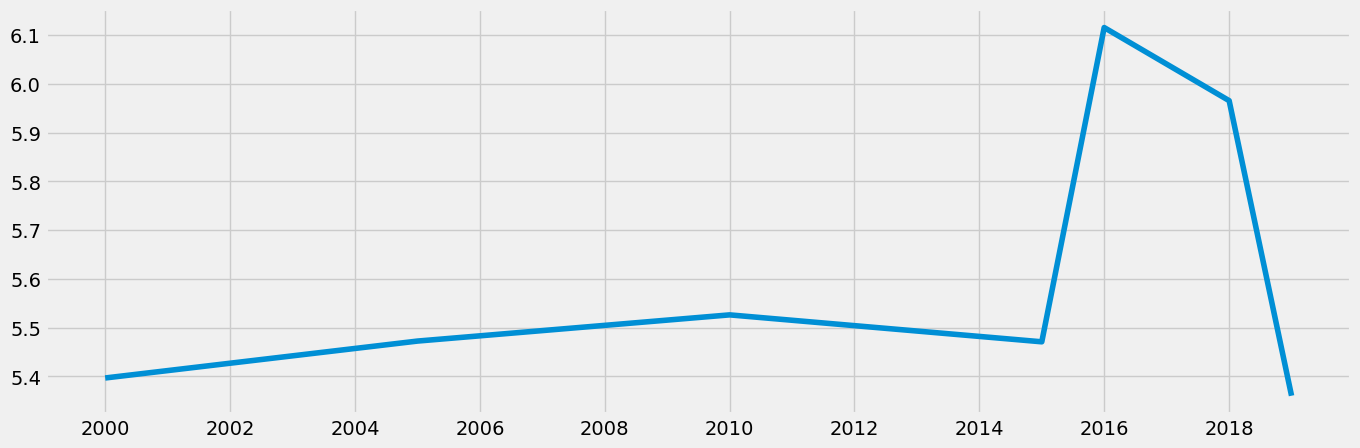

In [23]:
# Plot the global avergage data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(subset)


# 02. Subsetting, wrangling, and cleaning time-series data

Considering my D1 dataset has countryspecific values from 2005 to 2022 I will cut off any data before 2005. Out of interest I will also filter out the top 10 high consumption countries to see whether they have lower than average happiness rankings. I will continue the time series analysis afterwards on my d1 dataset to get some extra insights on my research hypothesis.

In [24]:
subset_1 = data.drop(columns=['series_id', 'country_code'])

In [25]:
subset_1.head()

,country_name,year,value
None,,,
0,Zimbabwe,2019,3.62809
1,Zimbabwe,2018,4.67000
2,Zimbabwe,2016,4.80000
3,Zimbabwe,2015,3.74794
4,Zimbabwe,2010,3.31307


In [26]:
subset_1.describe()

,year,value
count,1639.000000,1639.000000
mean,2011.874924,5.615227
std,6.616171,3.938675
min,2000.000000,0.000000
25%,2005.000000,2.287410
50%,2015.000000,5.170961
75%,2018.000000,8.635347
max,2019.000000,20.500000


In [27]:
subset_1.dtypes

country_name     object
year              int64
value           float64
dtype: object

In [28]:
# Narrow dataset to 2005 - 2019
subset_1 = subset_1.loc[(subset_1['year'] >= 2005)]

In [29]:
# Group the DataFrame by 'country_name'
grouped = subset_1.groupby('country_name').agg({'value':['mean']})

In [30]:
grouped.head()

,value
,mean
country_name,
Afghanistan,0.079028
Africa Eastern and Southern,4.866028
Africa Western and Central,5.200361
Albania,6.002430
Algeria,0.659992


In [31]:
# Reset the index to flatten the MultiIndex column labels
grouped.reset_index(inplace=True)

In [32]:
# Rename the column to remove the aggregation label
grouped.columns = ['country_name', 'value']

In [33]:
# Find top 10 consumption countries
grouped_top10 = grouped.nlargest(10, 'value')

In [34]:
grouped_top10

,country_name,value
179,Romania,15.703380
50,Czech Republic,14.400000
51,Czechia,13.654866
128,Lithuania,13.626400
223,Uganda,13.540660
65,Estonia,12.771927
80,Germany,12.683560
103,Ireland,12.608855
37,Central Europe and the Baltics,12.446879
132,Luxembourg,12.344165


In [35]:
# Narrow dataset to top 10 consumption countries (9 without grouped region Central Europe)
subset_1 = subset_1.loc[subset_1['country_name'].isin(['Romania','Czech Republic','Czechia','Lithuania','Uganda','Estonia','Germany','Ireland','Luxembourg'])]

In [36]:
# Group the DataFrame by 'country_name'
country = subset_1.groupby('country_name')

In [37]:
# Get a list of distinct colors for each country
import matplotlib.cm as cm
colors = cm.tab10.colors

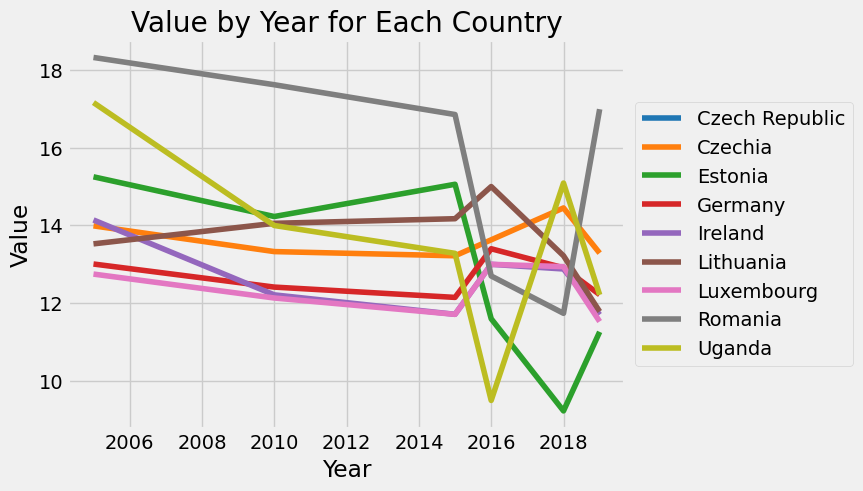

In [38]:
# Plot each group separately
for i, (name, group) in enumerate(country):
    color = colors[i % len(colors)]  # Cycle through colors if needed
    plt.plot(group['year'], group['value'], label=name, color=color)

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Value by Year for Each Country')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [39]:
# Create path
path = r'C:\Users\krist\21.02.2024 World Happiness Report Analysis'

In [50]:
# Import D1 full
d1_full = pd.read_csv(os.path.join(path, '02 Data', 'Sourced Data', 'd1_full_score_data (2005-2022).csv'), index_col = False)

In [54]:
d1_check = d1_full.loc[d1_full['country name'].isin(['Romania','Czech Republic','Czechia','Lithuania','Uganda','Estonia','Germany','Ireland','Luxembourg'])]

In [55]:
d1_check.groupby('country name').agg({'life Ladder':['mean']})

,life Ladder
,mean
country name,
Czechia,6.624143
Estonia,5.735875
Germany,6.824118
Ireland,7.040375
Lithuania,5.958294
Luxembourg,7.062250
Romania,5.725437
Uganda,4.299188


With an average life ladder ranking of 5.479227 actually all countries with the exception of Uganda are ranking above average.

### World happiness report analysis

In [56]:
# Import D1 filtered
d1_filt = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'd1_filtered.csv'), index_col = False)

In [59]:
d1_filt.head()

,Unnamed: 0,country name,year,life Ladder,log GDP per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect
0,23,Albania,2017,4.640,9.455,0.638,69.050,0.750,-0.031,0.876,0.547,0.334
1,24,Albania,2018,5.004,9.497,0.684,69.075,0.824,0.007,0.899,0.592,0.319
2,25,Albania,2019,4.995,9.522,0.686,69.100,0.777,-0.101,0.914,0.548,0.274
3,26,Albania,2020,5.365,9.492,0.710,69.125,0.754,0.004,0.891,0.563,0.265
4,27,Albania,2021,5.255,9.583,0.702,69.150,0.827,0.041,0.896,0.554,0.254


In [61]:
d1_filt = d1_filt.drop(columns = 'Unnamed: 0')

In [62]:
d1_filt.describe()

,year,life Ladder,log GDP per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect
count,534.000000,534.000000,526.000000,533.000000,522.000000,532.000000,525.000000,511.000000,530.000000,530.000000
mean,2019.500000,5.835041,9.746715,0.829268,66.038218,0.807776,-0.008181,0.716730,0.661911,0.279472
std,1.709426,1.039937,1.007235,0.115950,5.203859,0.103772,0.157709,0.193423,0.098388,0.085364
min,2017.000000,2.179000,5.527000,0.366000,52.150000,0.423000,-0.338000,0.151000,0.263000,0.083000
25%,2018.000000,5.098250,9.121750,0.770000,63.825000,0.740750,-0.125000,0.645000,0.598000,0.212000
50%,2019.500000,5.956000,9.875000,0.868000,66.425000,0.821000,-0.032000,0.780000,0.674500,0.269000
75%,2021.000000,6.516000,10.635750,0.920000,70.650000,0.887000,0.107000,0.853000,0.738750,0.333750
max,2022.000000,7.889000,11.625000,0.974000,74.475000,0.985000,0.552000,0.961000,0.826000,0.569000


In [63]:
d1_filt.isnull().sum()

country name                         0
year                                 0
life Ladder                          0
log GDP per capita                   8
social support                       1
healthy life expectancy at birth    12
freedom to make life choices         2
generosity                           9
perceptions of corruption           23
positive affect                      4
negative affect                      4
dtype: int64

In [64]:
# Create subset with relevant variables for hypothesis
d1_sub = d1_filt.drop(columns=['life Ladder','log GDP per capita','healthy life expectancy at birth', 'generosity', 'positive affect','negative affect' ])

In [65]:
d1_sub.isnull().sum()

country name                     0
year                             0
social support                   1
freedom to make life choices     2
perceptions of corruption       23
dtype: int64

In [66]:
d1_sub.shape

(534, 5)

~4% of data is missing. I will work with 'global' averages moving forward, so I consider the quantity of missing values neglectable for the full analysis.

In [67]:
d1_subg = d1_sub.groupby('year').agg({'social support':['mean'],'freedom to make life choices':['mean'],'perceptions of corruption':['mean']})

In [68]:
d1_subg

,social support,freedom to make life choices,perceptions of corruption
,mean,mean,mean
year,,,
2017,0.833852,0.803443,0.722155
2018,0.840910,0.807169,0.730881
2019,0.838910,0.814685,0.720271
2020,0.823629,0.814876,0.709647
2021,0.813854,0.801708,0.712057
2022,0.824506,0.804693,0.705837


In [69]:
d1_subg.dtypes

social support                mean    float64
freedom to make life choices  mean    float64
perceptions of corruption     mean    float64
dtype: object

In [70]:
d1_subg.columns

MultiIndex([(              'social support', 'mean'),
            ('freedom to make life choices', 'mean'),
            (   'perceptions of corruption', 'mean')],
           )

In [71]:
# Reset the index to flatten the MultiIndex column labels
d1_subg.reset_index(inplace=True)

In [72]:
# Rename the column to remove the aggregation label
d1_subg.columns = ['year', 'avg. social support score', 'avg. freedom to make life choices score', 'avg. perceptions of corruption score']

In [73]:
# Set year to index
d1_subg.set_index('year', inplace=True)

In [74]:
d1_subg.dtypes

avg. social support score                  float64
avg. freedom to make life choices score    float64
avg. perceptions of corruption score       float64
dtype: object

In [75]:
d1_subg.columns

Index(['avg. social support score', 'avg. freedom to make life choices score',
       'avg. perceptions of corruption score'],
      dtype='object')

In [76]:
# Change data format
d1_subg.index = pd.to_datetime(d1_subg.index, format='%Y')

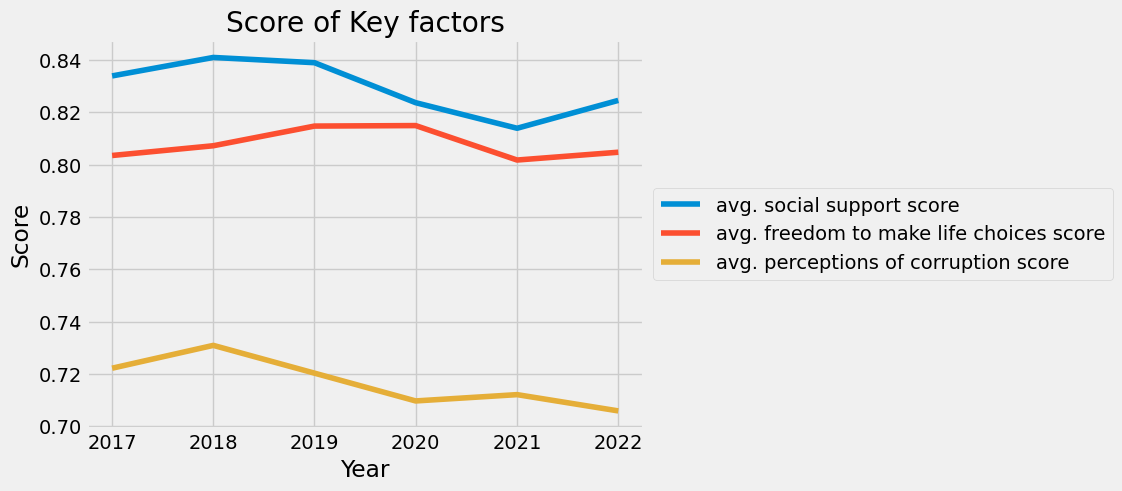

In [77]:
# Plot each column separately and specify labels for the legend
for column in d1_subg.columns:
    plt.plot(d1_subg.index, d1_subg[column], label=column)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Score of Key factors')

# Display legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### While the average 'social support' and 'perceptions of corruption score' dropped in 2020 (start of the pandemic), the 'ftmlc' scores stayed stable. Fluctuations overall were fairly limited.

In [78]:
# Check for missing values (you shouldn't have any)

d1_subg.isnull().sum() 

avg. social support score                  0
avg. freedom to make life choices score    0
avg. perceptions of corruption score       0
dtype: int64

In [79]:
# Check for duplicates

dups = d1_subg.duplicated()
dups.sum()

# No dups!

0

In [93]:
# Create second subset with life ladder only
d1_ll = d1_filt.drop(columns=['log GDP per capita','healthy life expectancy at birth', 'generosity', 'positive affect','negative affect', 'social support', 'freedom to make life choices', 'perceptions of corruption' ])

In [94]:
d1_ll.head()

,country name,year,life Ladder
0,Albania,2017,4.640
1,Albania,2018,5.004
2,Albania,2019,4.995
3,Albania,2020,5.365
4,Albania,2021,5.255


In [95]:
d1_llg = d1_ll.groupby('year').agg({'life Ladder':['mean']})

In [96]:
# Reset the index to flatten the MultiIndex column labels
d1_llg.reset_index(inplace=True)

In [97]:
# Rename the column to remove the aggregation label
d1_llg.columns = ['year', 'avg. life ladder score']

In [98]:
# Set year to index
d1_llg.set_index('year', inplace=True)

In [99]:
# Change data format
d1_llg.index = pd.to_datetime(d1_subg.index, format='%Y')

In [100]:
d1_llg

,avg. life ladder score
year,
2017-01-01,5.810607
2018-01-01,5.855213
2019-01-01,5.884079
2020-01-01,5.822124
2021-01-01,5.806517
2022-01-01,5.831708


In [101]:
d1_llg.dtypes

avg. life ladder score    float64
dtype: object

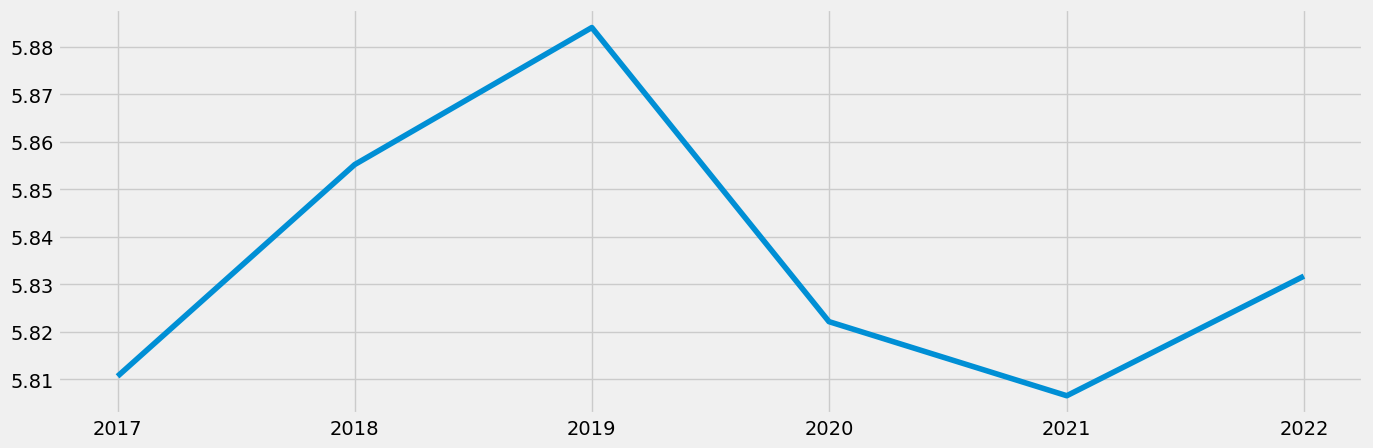

In [102]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(d1_llg)

#### 'Happiness scores' dropped ~0.06 points on average in 2020 (start of the pandemic) and dropped to below 2017 levels in 2021. Scores show improvement over '20 and '21 in 2022. Overall, fluctuations are fairly limited (I had expected more impact, starting this analysis).

#### Next I want to zoom into Germany specifically, taking a longer time frame since more comparable data is available.

In [104]:
# Create subset for Germany only with relevant variables for hypothesis
d1_ger = d1_full.drop(columns=['life Ladder','log GDP per capita','healthy life expectancy at birth', 'generosity', 'positive affect','negative affect' ])

In [105]:
# Pick Germany
d1_ger = d1_ger[d1_ger['country name'] == 'Germany']

In [106]:
d1_ger.isnull().sum()

country name                    0
year                            0
social support                  0
freedom to make life choices    0
perceptions of corruption       0
dtype: int64

In [107]:
d1_ger

,country name,year,social support,freedom to make life choices,perceptions of corruption
688,Germany,2005,0.963,0.847,0.781
689,Germany,2007,0.926,0.801,0.792
690,Germany,2008,0.923,0.766,0.758
691,Germany,2009,0.935,0.844,0.690
692,Germany,2010,0.939,0.843,0.688
693,Germany,2011,0.947,0.906,0.677
694,Germany,2012,0.926,0.904,0.679
695,Germany,2013,0.931,0.894,0.566
696,Germany,2014,0.938,0.899,0.474
697,Germany,2015,0.926,0.889,0.412


In [108]:
d1_ger = d1_ger.drop(columns=['country name'])

In [109]:
# Reset the index
d1_ger.reset_index(inplace=True)

In [110]:
# Set year to index
d1_ger.set_index('year', inplace=True)

In [111]:
# Change data format
d1_ger.index = pd.to_datetime(d1_ger.index, format='%Y')

In [112]:
d1_ger = d1_ger.drop(columns='index')

In [113]:
d1_ger

,social support,freedom to make life choices,perceptions of corruption
year,,,
2005-01-01,0.963,0.847,0.781
2007-01-01,0.926,0.801,0.792
2008-01-01,0.923,0.766,0.758
2009-01-01,0.935,0.844,0.690
2010-01-01,0.939,0.843,0.688
2011-01-01,0.947,0.906,0.677
2012-01-01,0.926,0.904,0.679
2013-01-01,0.931,0.894,0.566
2014-01-01,0.938,0.899,0.474


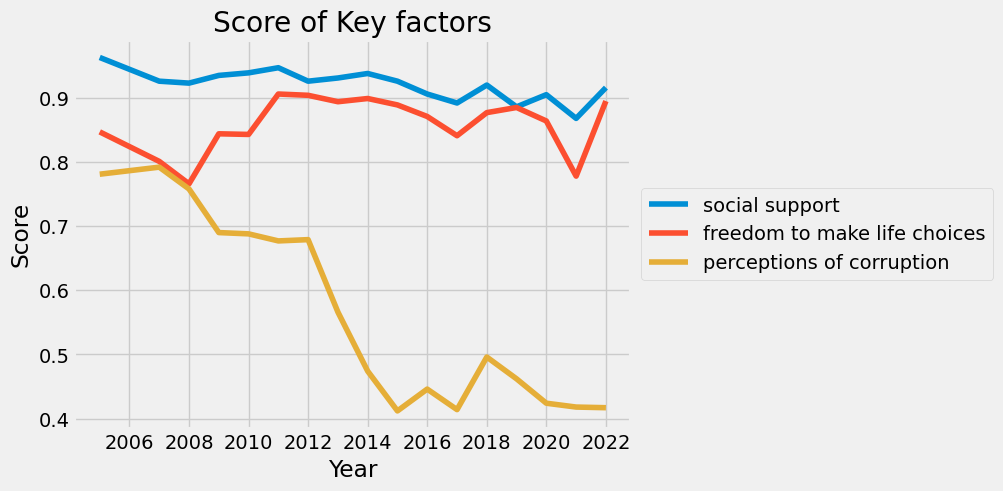

In [114]:
# Plot each column separately and specify labels for the legend
for column in d1_ger.columns:
    plt.plot(d1_ger.index, d1_ger[column], label=column)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Score of Key factors')

# Display legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### For Germany only there is a noticeable decrease in the social support score and freedom to make life choices score in 2021 and a clear recovery in 2022. Perceptions of corruption stayed consistenly low during the pandemic years.

In [115]:
# Create second subset with life ladder only for Germany
d1_ll_ger = d1_full.drop(columns=['log GDP per capita','healthy life expectancy at birth', 'generosity', 'positive affect','negative affect', 'social support', 'freedom to make life choices', 'perceptions of corruption' ])

In [116]:
# Pick Germany
d1_ll_ger = d1_ll_ger[d1_ll_ger['country name'] == 'Germany']

In [117]:
d1_ll_ger.isnull().sum()

country name    0
year            0
life Ladder     0
dtype: int64

In [118]:
d1_ll_ger = d1_ll_ger.drop(columns=['country name'])

In [119]:
# Reset the index
d1_ll_ger.reset_index(inplace=True)

In [120]:
d1_ll_ger

,index,year,life Ladder
0,688,2005,6.620
1,689,2007,6.417
2,690,2008,6.522
3,691,2009,6.641
4,692,2010,6.725
5,693,2011,6.621
6,694,2012,6.702
7,695,2013,6.965
8,696,2014,6.984
9,697,2015,7.037


In [121]:
d1_ll_ger.dtypes

index            int64
year             int64
life Ladder    float64
dtype: object

In [122]:
d1_ll_ger = d1_ll_ger.drop(columns=['index'])

In [123]:
# Set year to index
d1_ll_ger.set_index('year', inplace=True)

In [124]:
# Change data format
d1_ll_ger.index = pd.to_datetime(d1_ll_ger.index, format='%Y')

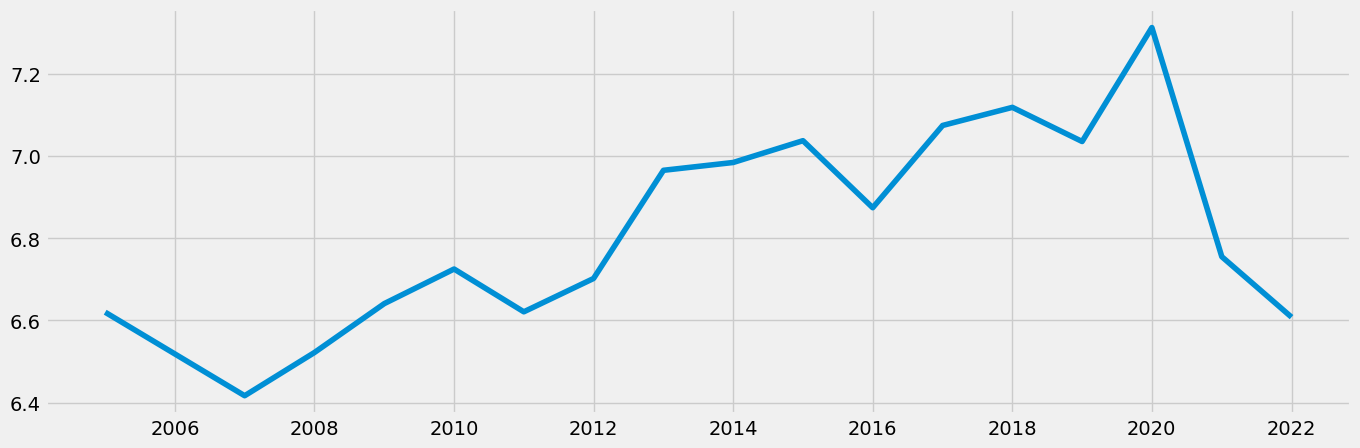

In [125]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(d1_ll_ger)

#### Overall ladder scores were at an all time high in 2020 (start of pandemic) with a steap drop in 2021 and 2022 which could point to a delayed pandemic impact. 2022 is on a low that previously was reached in 2011 (Euro Crisis?!)

# 03. Time-series analysis: decomposition

Since the data I have been looking at is not behaving in a linear fashion I will use a multiplicative decomposition model.

In [126]:
d1_ll_ger.dtypes

life Ladder    float64
dtype: object

In [127]:
d1_ll_ger

,life Ladder
year,
2005-01-01,6.620
2007-01-01,6.417
2008-01-01,6.522
2009-01-01,6.641
2010-01-01,6.725
2011-01-01,6.621
2012-01-01,6.702
2013-01-01,6.965
2014-01-01,6.984


In [128]:
# Convert the index to a datetime index with year start frequency
d1_ll_ger.index = pd.to_datetime(d1_ll_ger.index, format='%Y-%m-%d', errors='raise')

In [129]:
d1_ll_ger

,life Ladder
year,
2005-01-01,6.620
2007-01-01,6.417
2008-01-01,6.522
2009-01-01,6.641
2010-01-01,6.725
2011-01-01,6.621
2012-01-01,6.702
2013-01-01,6.965
2014-01-01,6.984


In [130]:
# Reset the index
d1_ll_ger.reset_index(inplace=True)

In [131]:
# Taking out 2005 because of issues with decomposition
d1_ll_ger = d1_ll_ger[d1_ll_ger['year'] >= '2007']

In [132]:
# Set year to index
d1_ll_ger.set_index('year', inplace=True)

In [133]:
d1_ll_ger

,life Ladder
year,
2007-01-01,6.417
2008-01-01,6.522
2009-01-01,6.641
2010-01-01,6.725
2011-01-01,6.621
2012-01-01,6.702
2013-01-01,6.965
2014-01-01,6.984
2015-01-01,7.037


In [134]:
# Decompose the time series d1_ll_ger

decomposition = sm.tsa.seasonal_decompose(d1_ll_ger, model='multiplicative')

In [135]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

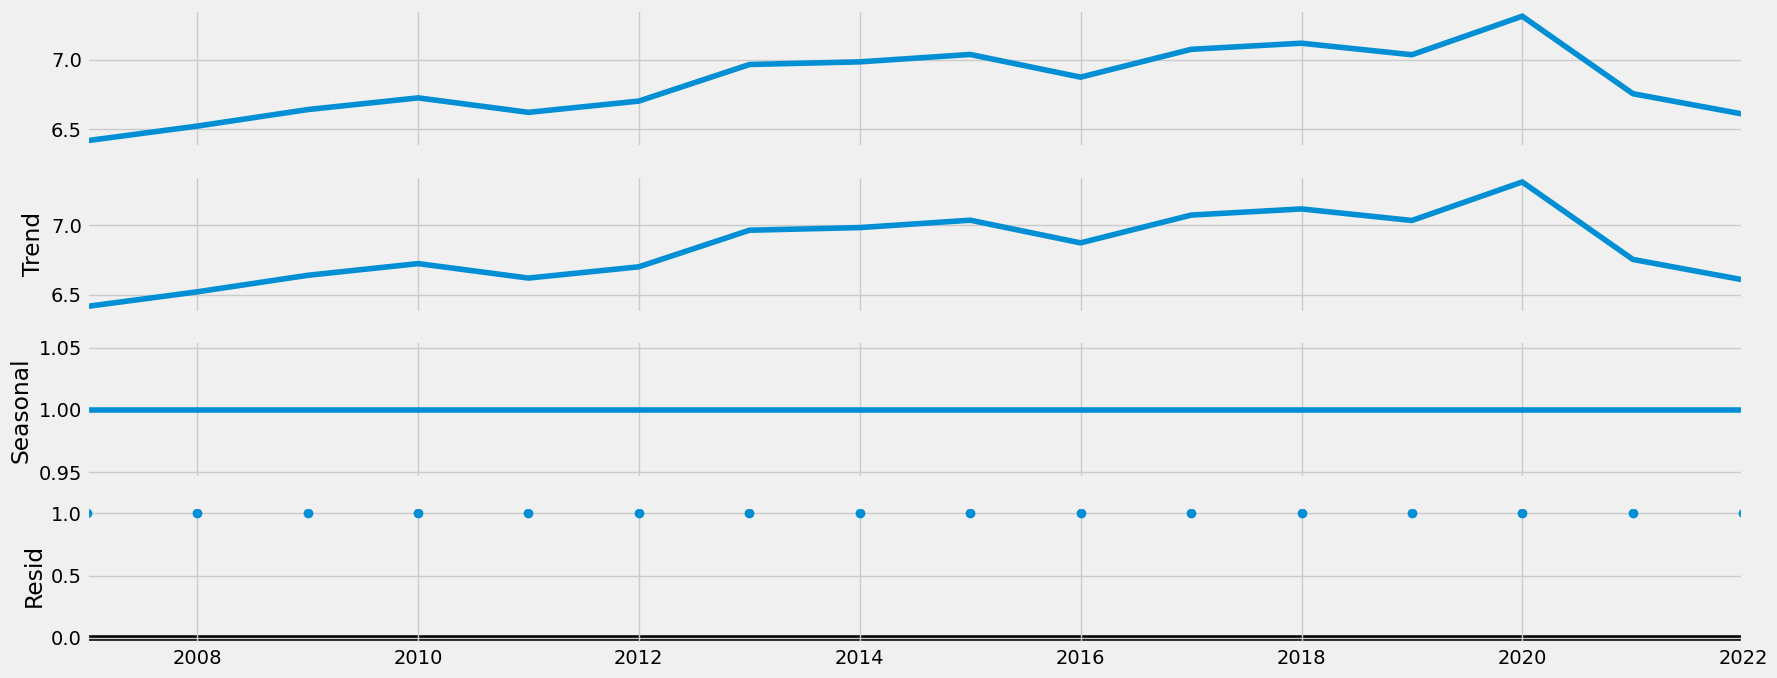

In [136]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Level and trend are the same since data is smoothed (no fluctuation in noise whatsoever). Dominant trend shows a gradual increase with highest peak in 2020 and steapest drop in 2021. Further drop in 2022 - first two-years-in-a-row-drop. No seasonality detected. --> Although the trend line is only showing a slight upwards trend and there is a flat seasonality the series might still be considered non-stationary

In [137]:
# Test decomposition on other variables
# Convert the index to a datetime index with year start frequency
d1_ger.index = pd.to_datetime(d1_ger.index, format='%Y-%m-%d', errors='raise')

In [138]:
# Reset the index
d1_ger.reset_index(inplace=True)

In [139]:
# Taking out 2005 because of issues with decomposition
d1_ger = d1_ger[d1_ger['year'] >= '2007']

In [140]:
# Focus on 'freedom to make life choices' variable
d1_f_ger = d1_ger.drop(columns=['social support','perceptions of corruption'])

In [141]:
# Set year to index
d1_f_ger.set_index('year', inplace=True)

In [142]:
d1_f_ger

,freedom to make life choices
year,
2007-01-01,0.801
2008-01-01,0.766
2009-01-01,0.844
2010-01-01,0.843
2011-01-01,0.906
2012-01-01,0.904
2013-01-01,0.894
2014-01-01,0.899
2015-01-01,0.889


In [143]:
# Decompose the time series d1_ger

decomposition_1 = sm.tsa.seasonal_decompose(d1_f_ger, model='multiplicative')

In [144]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

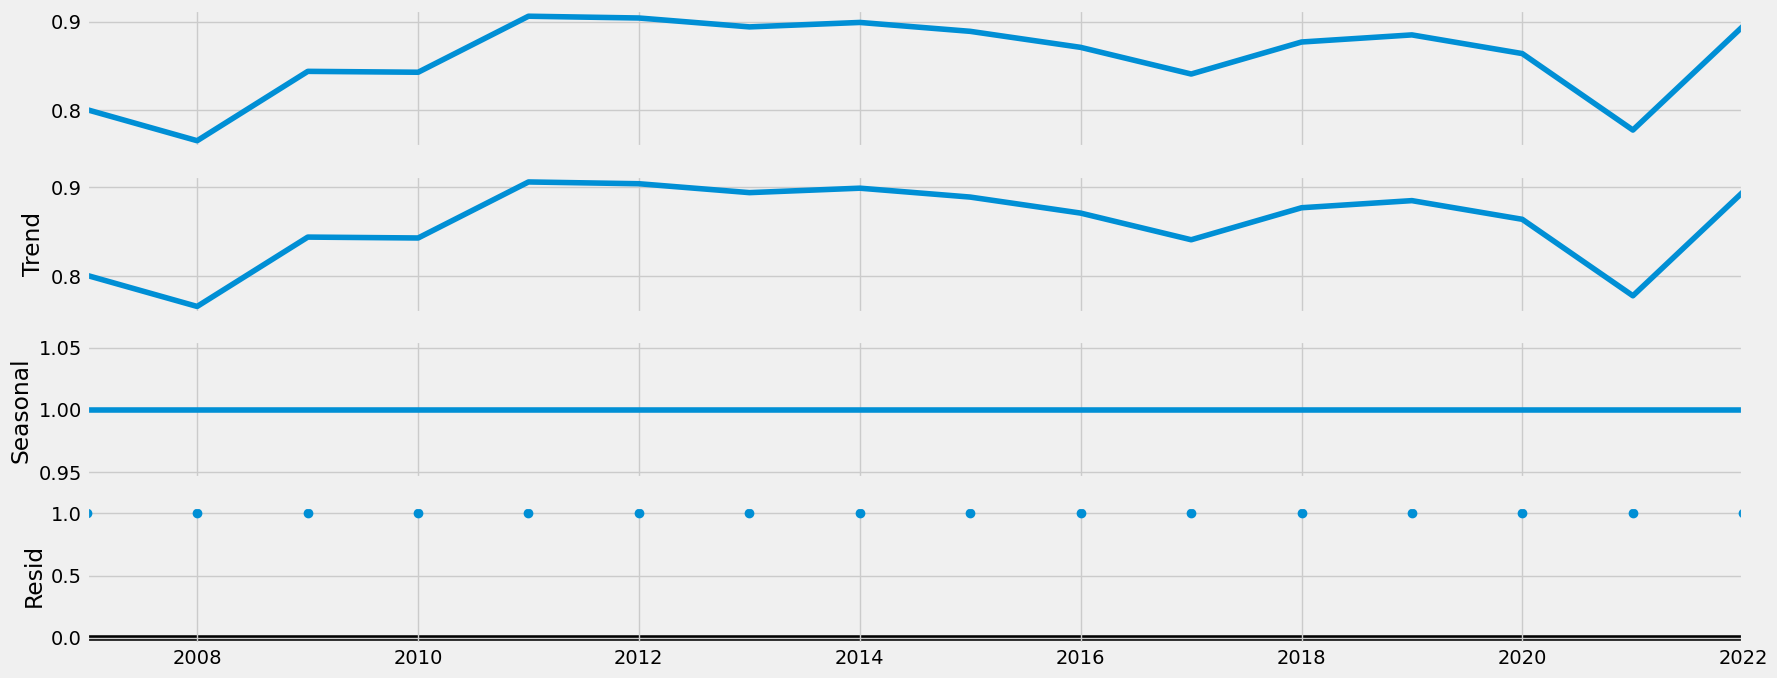

In [145]:
# Plot the separate components

decomposition_1.plot()
plt.show()

#### Level and trend are the same since data is smoothed (no fluctuation in noise whatsoever). Trend increased until peak in 2011, stable scores until 2014 until first bigger drop in 2017 after which scores improved until heavy drop in 2021 (in line with ladder score drop in the same year). No seasonality detected. --> Although the trend line is only showing a slight upwards trend and there is a flat seasonality the series might still be considered non-stationary

#### Timeline of the corona pandemic in Germany:
The first wave hit in March 2020 leading to different restrictions on state level to save the 'vulenerable' public. This included closings of schools and kindergardens, restrictions to visit nursing homes for the elderly, curfews or restrictions of contact between households (depending on the state) as well as rules to wear masks in public. With a second wave hitting towards Q4 of 2020 a partial lockdown was issues in November and a hard lockdown in December. The Third, Fourth and Fifth wave hit in 2021 with different variations of the virus and different pandemic measures in hard-hit districts and depending ion the vaccination status of citizens ('3G-rule'). Beginning of 2022 the RKI reported that just under 75% of the German population had been vaccinated. Restrictions were lifted.

The high ladder score in 2020 seems counter intuitive in light of the pandemic, however, from personal experience 2021 was a more difficult year since in 2020 the extent and duration of the pandemic was still very much unclear, while 2021 had turned a lot of restrictions into 'the new normal'. 2020 also saw an unparalleled global comparison in a. how hard different countries were hit by the pandemic b. how efficient the governments handled the crisis and c. how save / restricted people felt.

# 04. Testing for stationarity

    Null Hypothesis: There is a unit root (therefore the series is non-stationary)
    Alternative Hypothesis: There is no unit root (therefore the series is stationary) --> Proceed with forecast

In [146]:
# Dickey fuller test on the d1_ll_ger
# The adfuller() function imports from the model from statsmodels for the test; Running it will return 
# an array of numbers. Afterwards define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(d1_ll_ger['life Ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.117744
p-value                         0.237440
Number of Lags Used             0.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


Result: There is a unit root in the data / data is non-stationary
Test statistic is larger than the critical values --> Null hypothesis cannot be rejected 
p-value > 0.05 (not significant)

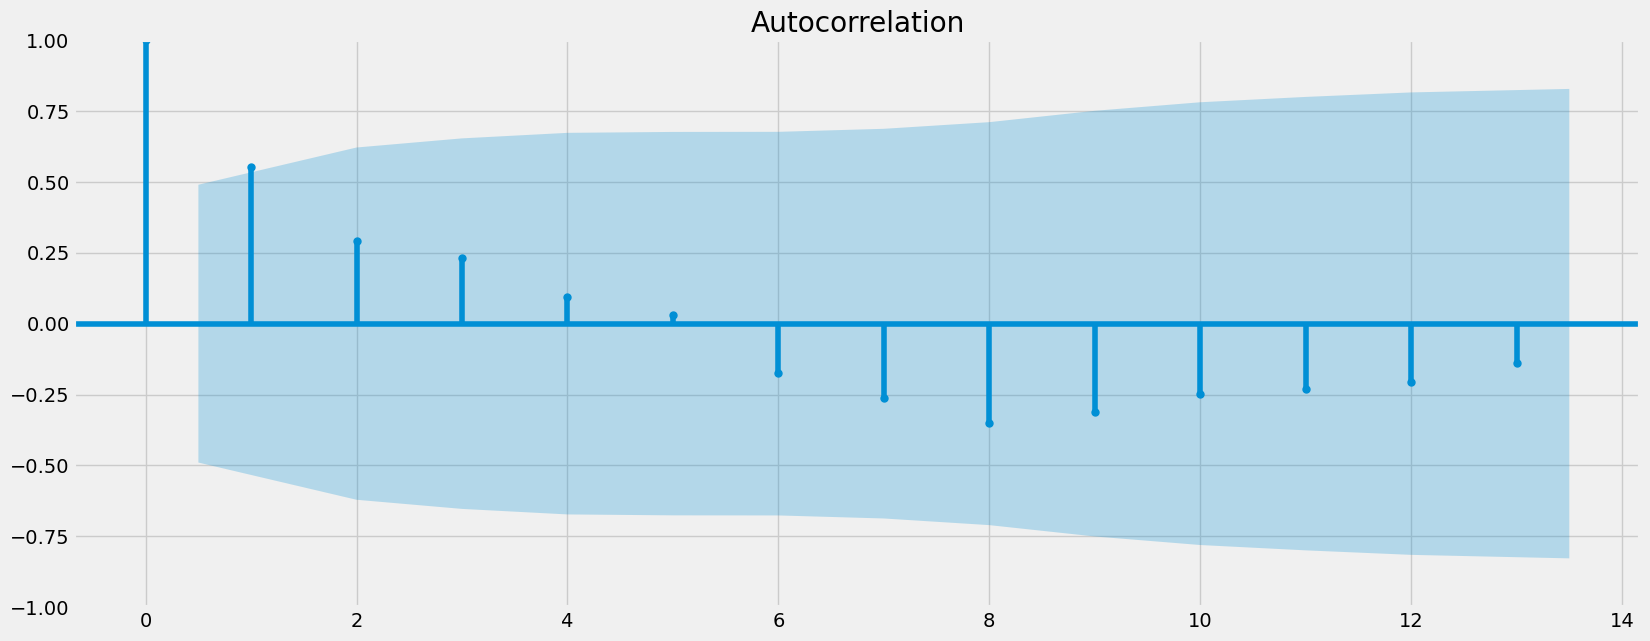

In [147]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(d1_ll_ger)
plt.show()

Only one lag out of confidence interval indicates little siginificant autocorrelation. Stationary or not questionable from these results, but Dickey_fuller test suggest a non-stationary time series.

In [148]:
# Dickey fuller test on the d1_f_ger
# The adfuller() function imports from the model from statsmodels for the test; Running it will return 
# an array of numbers. Afterwards define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(d1_f_ger['freedom to make life choices'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.205031
p-value                         0.019695
Number of Lags Used             5.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


Result: There is a unit root in the data / data is non-stationary
Test statistic is larger than the critical value of 5% --> Null hypothesis cannot be rejected 
p-value < 0.05 (significant)

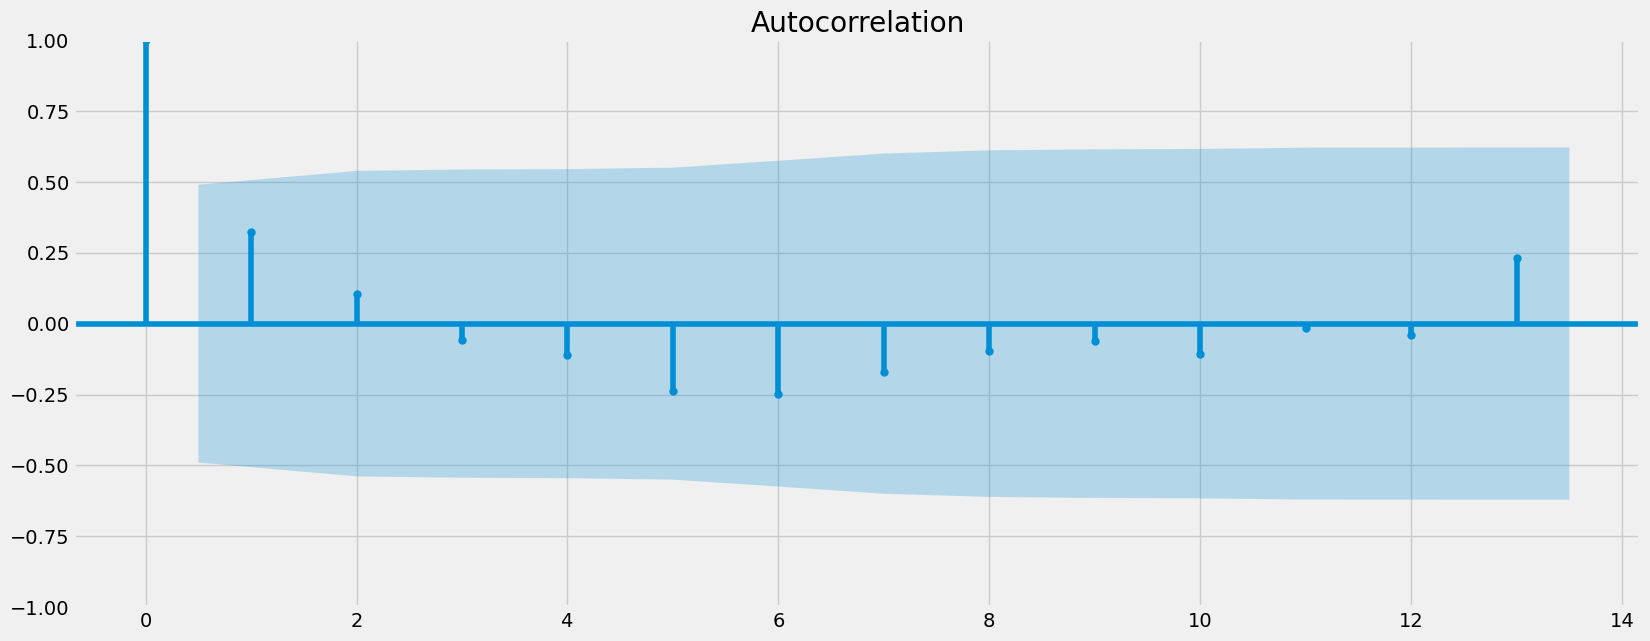

In [149]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(d1_f_ger)
plt.show()

Similar results to other dataset. Only one lag out of confidence interval indicates little siginificant autocorrelation. Stationary or not questionable from these results, but Dickey_fuller test suggest a non-stationary time series.

# 05. Stationarizing the WHR Data for Germany

In [150]:
# For dataframe d1_ll_ger
data_diff = d1_ll_ger - d1_ll_ger.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [151]:
data_diff.dropna(inplace = True) # Remove missing values that came about as a result of the differencing. 
# Need to be removed to run the Dickey-Fuller test.

In [152]:
data_diff.head()

,life Ladder
year,
2008-01-01,0.105
2009-01-01,0.119
2010-01-01,0.084
2011-01-01,-0.104
2012-01-01,0.081


In [153]:
data_diff.columns

Index(['life Ladder'], dtype='object')

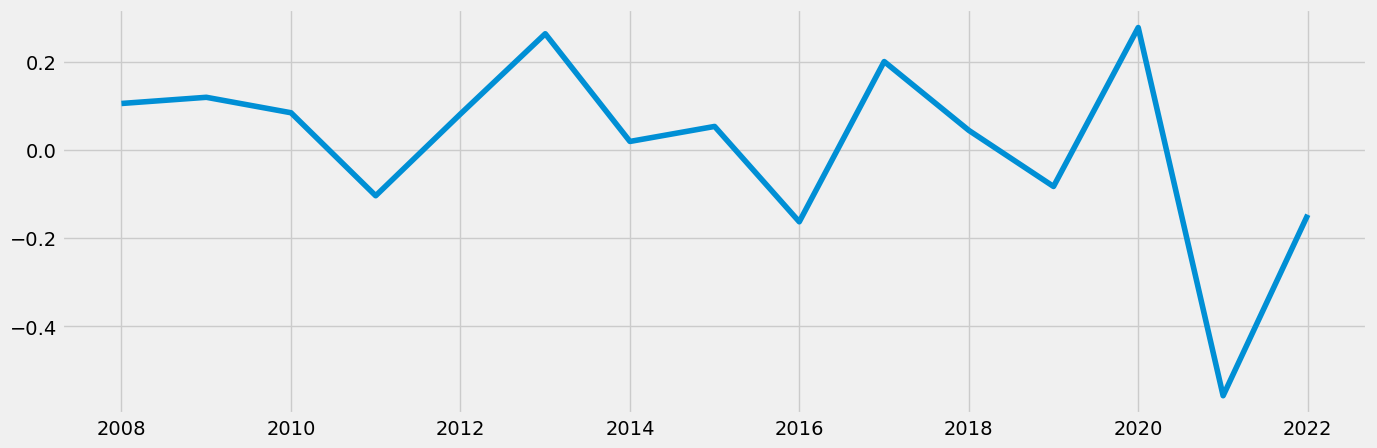

In [154]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [155]:
# Run another dickey fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.069033
p-value                         0.001089
Number of Lags Used             0.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


Result: There is no unit root in the data / data is stationary
Test statistic is smaller than the critical values --> Null hypothesis can be rejected 
p-value < 0.05 (significant)

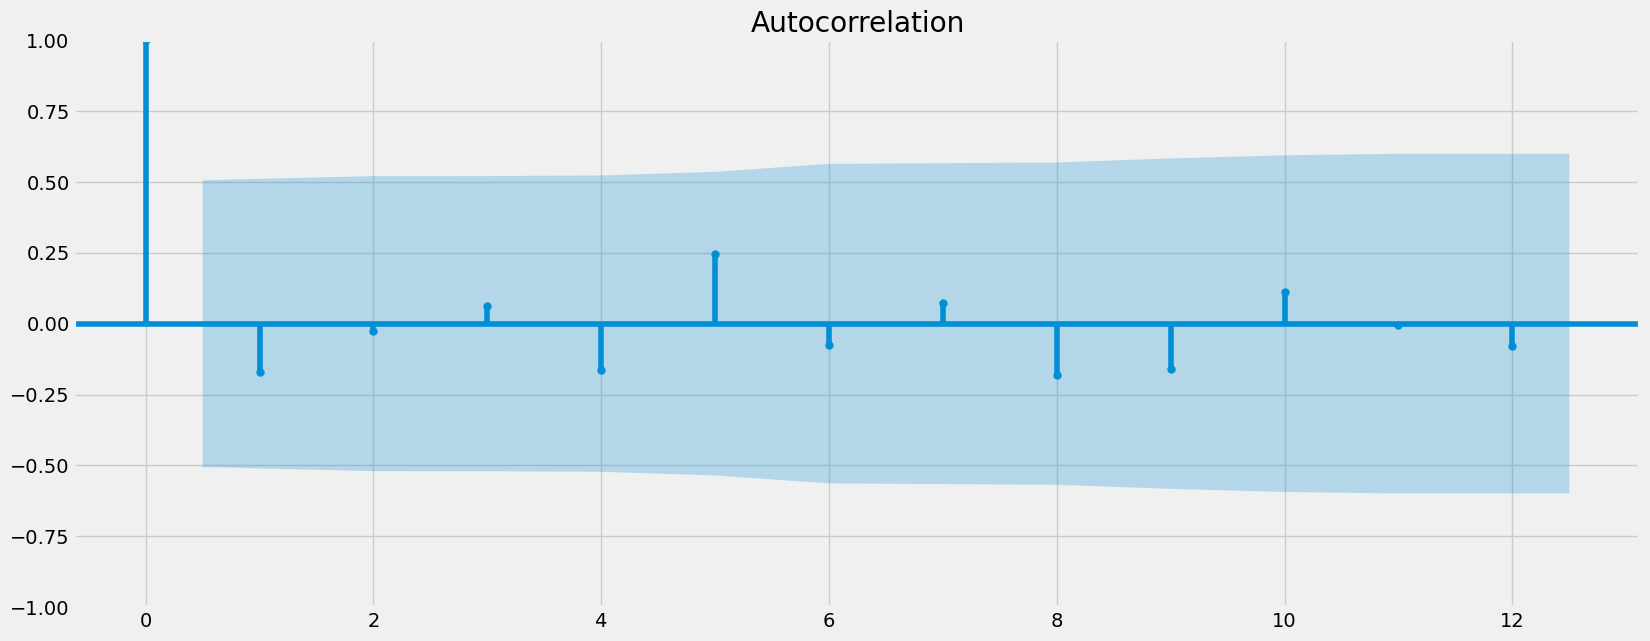

In [156]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

Still one lag out of confidence interval. Indicates little siginificant autocorrelation (rule of thumb <10 siginificant lags don't ask for a second round of differencing.

In [157]:
# For dataframe d1_f_ger
d1_f_diff = d1_f_ger - d1_f_ger.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [158]:
d1_f_diff.dropna(inplace = True) # Remove missing values that came about as a result of the differencing. 
# Need to be removed to run the Dickey-Fuller test.

In [159]:
d1_f_diff.head()

,freedom to make life choices
year,
2008-01-01,-0.035
2009-01-01,0.078
2010-01-01,-0.001
2011-01-01,0.063
2012-01-01,-0.002


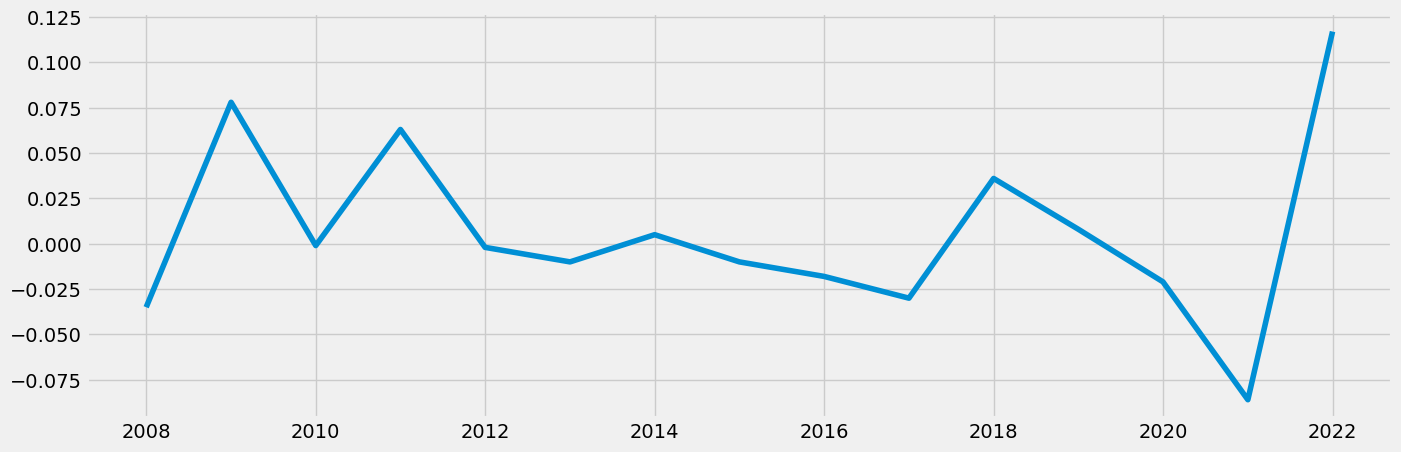

In [160]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(d1_f_diff)

In [161]:
# Run another dickey fuller test
dickey_fuller(d1_f_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.959533
p-value                        0.304593
Number of Lags Used            5.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


Result: There still is a unit root in the data / data is non-stationary
Test statistic is larger than the critical values --> Null hypothesis cannot be rejected 
p-value < 0.05 (not significant)

In [162]:
# Second round for dataframe d1_f_ger
d1_f_diff_2 = d1_f_diff - d1_f_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [163]:
d1_f_diff_2.dropna(inplace = True) # Remove missing values that came about as a result of the differencing. 
# Need to be removed to run the Dickey-Fuller test.

In [164]:
d1_f_diff_2.head()

,freedom to make life choices
year,
2009-01-01,0.113
2010-01-01,-0.079
2011-01-01,0.064
2012-01-01,-0.065
2013-01-01,-0.008


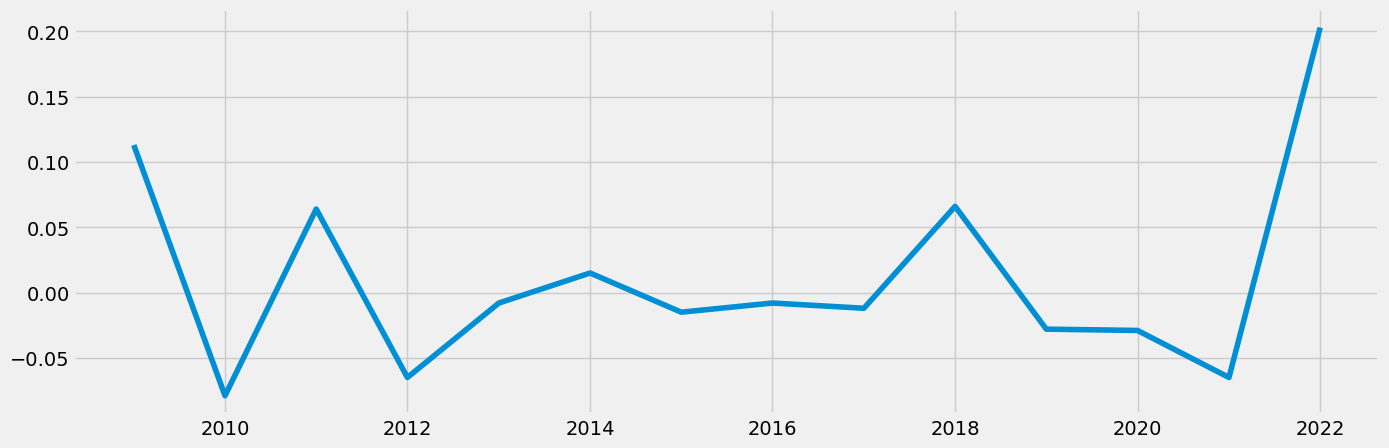

In [165]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(d1_f_diff_2)

In [166]:
# Run another dickey fuller test
dickey_fuller(d1_f_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.301766
p-value                         0.000441
Number of Lags Used             2.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


Result: There still is no unit root in the data / data is stationary
Test statistic is smaller than the critical values --> Null hypothesis can be rejected 
p-value < 0.05 (significant)

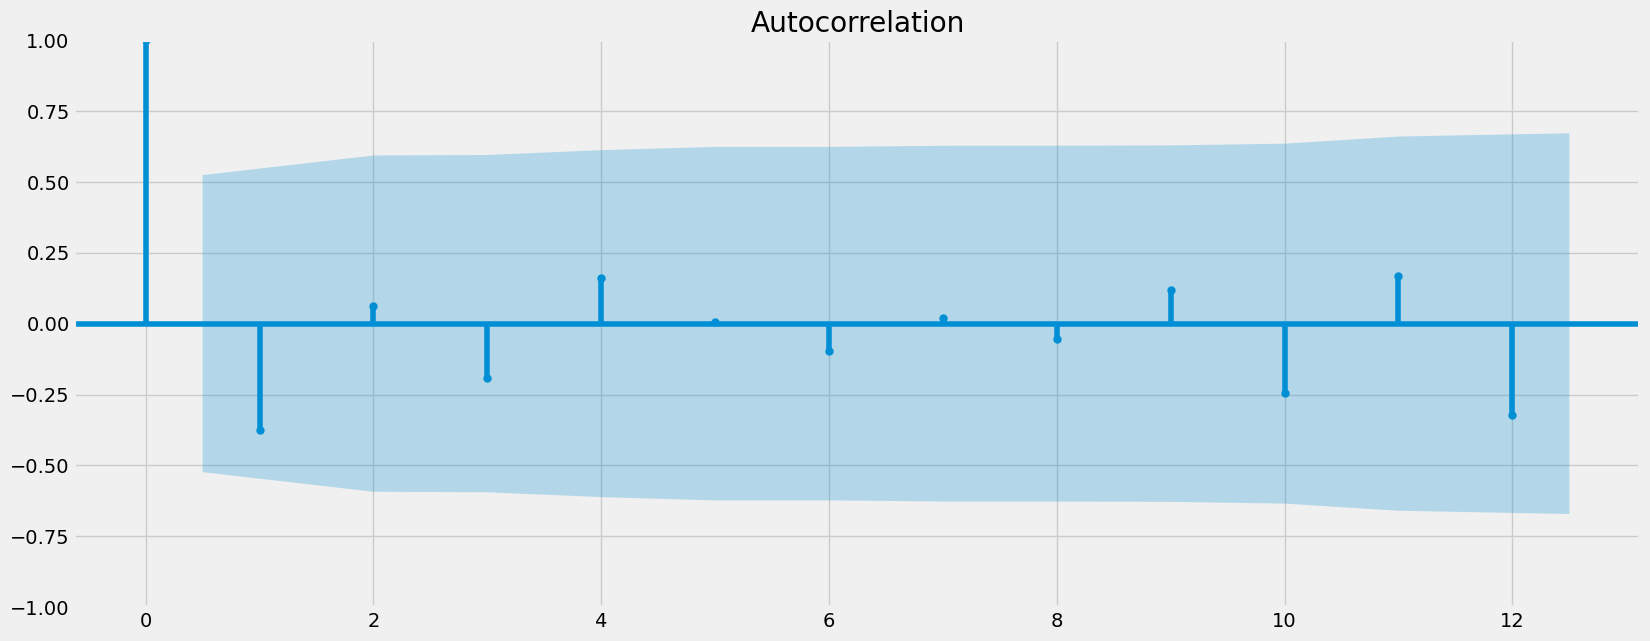

In [167]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(d1_f_diff_2)
plt.show()

Still one lag out of confidence interval. Indicates little significant autocorrelation (rule of thumb <10 siginificant lags don't ask for a second round of differencing.